In [1]:
from molecule_validation import validation_func

c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\paulj\Desktop\Master\venv\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import socket
from typing import Dict, List, Tuple

import torch
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from numpy.linalg import norm

from gflownet import GFNTask, LogScalar, ObjectProperties
from gflownet.config import Config, init_empty
from gflownet.envs.mol_building_env import MolBuildingEnvContext
from gflownet.online_trainer import StandardOnlineTrainer
import json
import os
import pathlib
import numpy as np
from rdkit.Chem.Draw import MolsToGridImage, MolToImage
from pom_models.functions import fragance_propabilities_from_smiles

TARGET_SMILES = "COC1=C(C=CC(=C1)C=O)O"
TARGET_VEC = fragance_propabilities_from_smiles(TARGET_SMILES)[0]

class MakeRingsTask(GFNTask):
    """A toy task where the reward is the number of rings in the molecule."""

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        # Encoding lets the model know that codniotional information is applied
        return {"encoding": torch.ones(n, 1),"reward_scheduling": torch.ones(n,1)*train_it}

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], obj_props: ObjectProperties) -> LogScalar:
        #cond_info["reward_scheduling"]
        scalar_logreward = torch.as_tensor(obj_props).squeeze().clamp(min=1e-30).log()
        return LogScalar(scalar_logreward.flatten())

    def compute_obj_properties(self, mols: List[RDMol]) -> Tuple[ObjectProperties, Tensor]:
        #is_valid = torch.tensor([m.GetNumAtoms() > 1 and Chem.Descriptors.NumRadicalElectrons(m) == 0 for m in mols ]).bool()
        is_valid = torch.tensor([validation_func(m) for m in mols ]).bool()
        if not is_valid.any():
            return ObjectProperties(torch.zeros((0,1))), is_valid
        valid_mols = [mol for mol, valid in zip(mols, is_valid) if valid]
        def reward_func(m):
            m_smiles = Chem.MolToSmiles(m)
            m_vec = fragance_propabilities_from_smiles(m_smiles)[0]
            return self.cosine_similarity(TARGET_VEC,m_vec)
        #rs = torch.tensor([m.GetRingInfo().NumRings() + get_flour(m) for m in mols]).float()
        rs = torch.tensor([reward_func(m) for m in valid_mols]).float()
        return ObjectProperties(rs.reshape((-1, 1))), is_valid
    
    def cosine_similarity(self,vec1,vec2):
        return np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))


class MakeRingsTrainer(StandardOnlineTrainer):
    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.num_workers = 8
        cfg.algo.num_from_policy = 64
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 20
        cfg.algo.sampling_tau = 0.9
        cfg.algo.illegal_action_logreward = -75
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0
        cfg.algo.tb.do_parameterize_p_b = True

        cfg.replay.use = False

    def setup_task(self):
        self.task = MakeRingsTask()

    def setup_env_context(self):
        self.ctx = MolBuildingEnvContext(
            ["C","N","O","F"],
            charges=[0],  # disable charge
            chiral_types=[Chem.rdchem.ChiralType.CHI_UNSPECIFIED],  # disable chirality
            num_rw_feat=0,
            expl_H_range=[0],
            max_nodes=self.cfg.algo.max_nodes,
            num_cond_dim=1,
        )


def save_run(trial):
    state = {
        "models_state_dict": [trial.model.state_dict()],
        "cfg": trial.cfg,
        "env_ctx": trial.model.env_ctx,
        #"model": trial.model,
    }
    if trial.sampling_model is not trial.model:
        state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
    fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
    with open(fn, "wb") as fd:
        torch.save(
            state,
            fd,
        )




  



c:\Users\paulj\Desktop\Master\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
"""Example of how this model can be run."""
config = init_empty(Config())
config.print_every = 1
config.log_dir = "./logs/debug_run_mr12"

# For CPU
config.device = torch.device('cpu')
config.num_workers = 0

# For reproduction
config.seed = 1 

config.num_training_steps = 50 #10_000

config.algo.tb.do_parameterize_p_b = False # Dont know how to load the model with this parameter = True
config.num_validation_gen_steps = 1



trial = MakeRingsTrainer(config)
trial.run()
save_run(trial)




Hyperparameters:

desc: noDesc
log_dir: ./logs/debug_run_mr12
device: cpu
seed: 1
validate_every: 1000
checkpoint_every: null
store_all_checkpoints: false
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 50
num_workers: 0
hostname: LAPTOP-JIE0TNQT
pickle_mp_messages: false
git_hash: unknown
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 20
  max_edges: 128
  illegal_action_logreward: -75.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_predict_n: false
    do_sample_p_b: false
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.0001
    Z_lr_de

[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:26:45] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:27:34 - INFO - logger - iteration 26 : offline_loss:0.00 online_loss:17400.52 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.22 loss:17400.52 n_loss:0.00 tb_loss:17400.52 batch_entropy:53.92 traj_lens:42.67 grad_norm:85489.96 grad_norm_clip:99.55 sampled_reward_avg:0.02 train_time:19.71 time_spent:55.26


[14:27:38] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:38] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:38] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:38] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:38] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:38] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:27:57] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:28:24 - INFO - logger - iteration 27 : offline_loss:0.00 online_loss:20082.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.27 loss:20082.43 n_loss:0.00 tb_loss:20082.43 batch_entropy:48.28 traj_lens:43.55 grad_norm:170346.02 grad_norm_clip:99.54 sampled_reward_avg:0.02 train_time:20.21 time_spent:49.93


[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:28:28] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:29:11 - INFO - logger - iteration 28 : offline_loss:0.00 online_loss:16858.08 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.31 loss:16858.08 n_loss:0.00 tb_loss:16858.08 batch_entropy:52.97 traj_lens:41.73 grad_norm:187732.66 grad_norm_clip:99.55 sampled_reward_avg:0.02 train_time:18.59 time_spent:46.84


[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:15] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:29:54 - INFO - logger - iteration 29 : offline_loss:0.00 online_loss:12070.77 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.36 loss:12070.77 n_loss:0.00 tb_loss:12070.77 batch_entropy:61.16 traj_lens:39.38 grad_norm:155464.95 grad_norm_clip:99.53 sampled_reward_avg:0.02 train_time:16.29 time_spent:43.06


[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:29:57] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:30:32 - INFO - logger - iteration 30 : offline_loss:0.00 online_loss:9243.05 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.40 loss:9243.05 n_loss:0.00 tb_loss:9243.05 batch_entropy:71.16 traj_lens:38.00 grad_norm:126439.62 grad_norm_clip:99.52 sampled_reward_avg:0.01 train_time:15.89 time_spent:37.36


[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:30:36] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:31:20 - INFO - logger - iteration 31 : offline_loss:0.00 online_loss:6438.08 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.45 loss:6438.08 n_loss:0.00 tb_loss:6438.08 batch_entropy:94.82 traj_lens:41.47 grad_norm:108284.46 grad_norm_clip:99.02 sampled_reward_avg:0.04 train_time:19.34 time_spent:48.74


[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:31:23] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:32:05 - INFO - logger - iteration 32 : offline_loss:0.00 online_loss:7476.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.49 loss:7476.51 n_loss:0.00 tb_loss:7476.51 batch_entropy:87.95 traj_lens:40.02 grad_norm:88861.93 grad_norm_clip:99.52 sampled_reward_avg:0.02 train_time:16.81 time_spent:44.22


[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:07] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:32:37 - INFO - logger - iteration 33 : offline_loss:0.00 online_loss:12338.24 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.54 loss:12338.24 n_loss:0.00 tb_loss:12338.24 batch_entropy:50.74 traj_lens:34.92 grad_norm:45968.89 grad_norm_clip:99.34 sampled_reward_avg:0.01 train_time:13.29 time_spent:32.73


[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:32:41] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:33:17 - INFO - logger - iteration 34 : offline_loss:0.00 online_loss:16082.51 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.58 loss:16082.51 n_loss:0.00 tb_loss:16082.51 batch_entropy:40.09 traj_lens:36.45 grad_norm:32209.20 grad_norm_clip:99.27 sampled_reward_avg:0.02 train_time:15.55 time_spent:39.40


[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:20] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:33:39] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:34:04 - INFO - logger - iteration 35 : offline_loss:0.00 online_loss:22896.79 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.63 loss:22896.79 n_loss:0.00 tb_loss:22896.79 batch_entropy:32.56 traj_lens:42.22 grad_norm:32882.20 grad_norm_clip:97.16 sampled_reward_avg:0.01 train_time:18.89 time_spent:47.30


[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:07] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:34:41 - INFO - logger - iteration 36 : offline_loss:0.00 online_loss:21124.17 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.68 loss:21124.17 n_loss:0.00 tb_loss:21124.17 batch_entropy:26.40 traj_lens:37.25 grad_norm:46612.93 grad_norm_clip:96.50 sampled_reward_avg:0.01 train_time:14.24 time_spent:36.99


[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:34:44] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:35:10 - INFO - logger - iteration 37 : offline_loss:0.00 online_loss:17799.25 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.73 loss:17799.25 n_loss:0.00 tb_loss:17799.25 batch_entropy:22.48 traj_lens:32.36 grad_norm:50436.90 grad_norm_clip:96.50 sampled_reward_avg:0.01 train_time:11.52 time_spent:29.32


[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:13] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:23] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:35:39 - INFO - logger - iteration 38 : offline_loss:0.00 online_loss:15183.02 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.77 loss:15183.02 n_loss:0.00 tb_loss:15183.02 batch_entropy:27.64 traj_lens:32.27 grad_norm:66355.84 grad_norm_clip:97.07 sampled_reward_avg:0.02 train_time:11.35 time_spent:28.57


[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:35:41] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:36:02 - INFO - logger - iteration 39 : offline_loss:0.00 online_loss:12820.76 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.82 loss:12820.76 n_loss:0.00 tb_loss:12820.76 batch_entropy:26.37 traj_lens:28.61 grad_norm:71381.27 grad_norm_clip:97.51 sampled_reward_avg:0.00 train_time:9.70 time_spent:23.60


[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:05] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:12] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:36:24 - INFO - logger - iteration 40 : offline_loss:0.00 online_loss:9802.54 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.87 loss:9802.54 n_loss:0.00 tb_loss:9802.54 batch_entropy:29.25 traj_lens:26.73 grad_norm:68344.70 grad_norm_clip:97.21 sampled_reward_avg:0.04 train_time:8.47 time_spent:21.80


[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:27] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:36:40 - INFO - logger - iteration 41 : offline_loss:0.00 online_loss:7344.23 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.92 loss:7344.23 n_loss:0.00 tb_loss:7344.23 batch_entropy:25.94 traj_lens:21.64 grad_norm:49022.03 grad_norm_clip:96.69 sampled_reward_avg:0.01 train_time:5.92 time_spent:16.13


[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:46] WARNING: could not find number of expected rings. Switching to an approximate ring fi

26/03/2025 14:36:53 - INFO - logger - iteration 42 : offline_loss:0.00 online_loss:5551.32 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-1.97 loss:5551.32 n_loss:0.00 tb_loss:5551.32 batch_entropy:23.73 traj_lens:16.95 grad_norm:35862.05 grad_norm_clip:96.06 sampled_reward_avg:0.02 train_time:4.19 time_spent:12.16


[14:36:54] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:54] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:56] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:36:57] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


26/03/2025 14:37:00 - INFO - logger - iteration 43 : offline_loss:0.00 online_loss:4409.11 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.01 loss:4409.11 n_loss:0.00 tb_loss:4409.11 batch_entropy:16.86 traj_lens:11.98 grad_norm:19464.35 grad_norm_clip:95.13 sampled_reward_avg:0.01 train_time:2.10 time_spent:7.06


[14:37:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:01] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:02] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:02] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:03] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


26/03/2025 14:37:05 - INFO - logger - iteration 44 : offline_loss:0.00 online_loss:4127.29 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.06 loss:4127.29 n_loss:0.00 tb_loss:4127.29 batch_entropy:13.85 traj_lens:9.22 grad_norm:14288.28 grad_norm_clip:94.48 sampled_reward_avg:0.00 train_time:1.36 time_spent:5.15
26/03/2025 14:37:09 - INFO - logger - iteration 45 : offline_loss:0.00 online_loss:3829.58 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.11 loss:3829.58 n_loss:0.00 tb_loss:3829.58 batch_entropy:10.02 traj_lens:6.95 grad_norm:10035.05 grad_norm_clip:93.32 sampled_reward_avg:0.01 train_time:0.83 time_spent:4.18


[14:37:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:10] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:11] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[14:37:11] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


26/03/2025 14:37:12 - INFO - logger - iteration 46 : offline_loss:0.00 online_loss:3762.43 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.16 loss:3762.43 n_loss:0.00 tb_loss:3762.43 batch_entropy:9.17 traj_lens:5.70 grad_norm:11003.49 grad_norm_clip:93.16 sampled_reward_avg:0.00 train_time:0.63 time_spent:2.97
26/03/2025 14:37:15 - INFO - logger - iteration 47 : offline_loss:0.00 online_loss:3534.61 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.22 loss:3534.61 n_loss:0.00 tb_loss:3534.61 batch_entropy:10.63 traj_lens:5.45 grad_norm:13991.69 grad_norm_clip:94.41 sampled_reward_avg:0.00 train_time:0.58 time_spent:2.80
26/03/2025 14:37:17 - INFO - logger - iteration 48 : offline_loss:0.00 online_loss:3617.00 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-2.27 loss:3617.00 n_loss:0.00 tb_loss:

structural similarity
different chemical parameter

Change reward in later epochs to consider descriptor. 

1 step invalid 

In [4]:
from rdkit.Chem.Draw import MolsToGridImage, MolToImage

In [5]:
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]

In [6]:
obj_props, is_valid = trial.task.compute_obj_properties(objs)

In [7]:
is_valid

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])

In [8]:
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)

In [9]:
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)
log_rewards

tensor([])

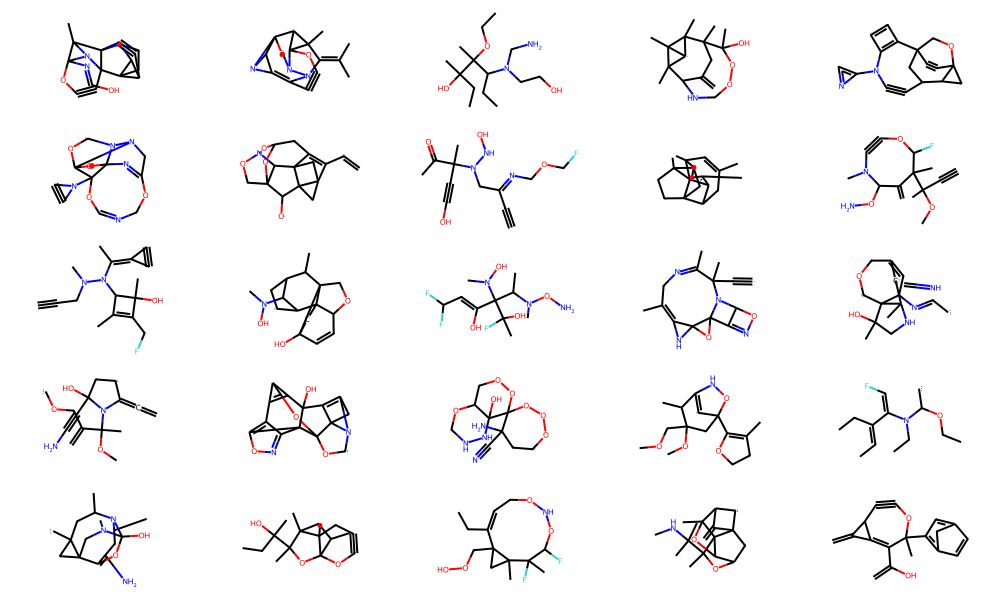

In [43]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
cond_info = trial.task.sample_conditional_information(len(obj_props), 1)
log_rewards = trial.task.cond_info_to_logreward(cond_info, obj_props)


MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120))#, legends=[f'reward: {r.exp().item():.2f}' for r in log_rewards[:25]])

In [ ]:
2

1

Model training might be wrong



In [7]:
print([Chem.MolToSmiles(obj) for obj in objs])

['[O]OO[C]1[CH]O1', '[C]NC(O)C#N', 'COC1[N][CH]O1', 'N=C1C2C3=CC132', 'CN=C(F)O[NH]', 'OONOOO', '[CH]OC(F)OF', 'OON1C2ON21', '[N]n1on1ON', 'CC1CCN1[N]', 'CC=NOO', '[C]N1NC(=[CH])O1', 'N1OC23NN2N13', 'CC(O)(F)CN', 'CN(F)OC#N', 'FNN(F)OF', '[C]OC([O])N=O', 'NN=NC1[C]O1', '[N]C1(O)CN1O', 'n1on2o[nH]c12', '[N][C]1[N]NN1O', 'C1NNN2CN12', 'NC(O)(F)OO', '[NH][C](OO)OF', 'CO[C]=COC']


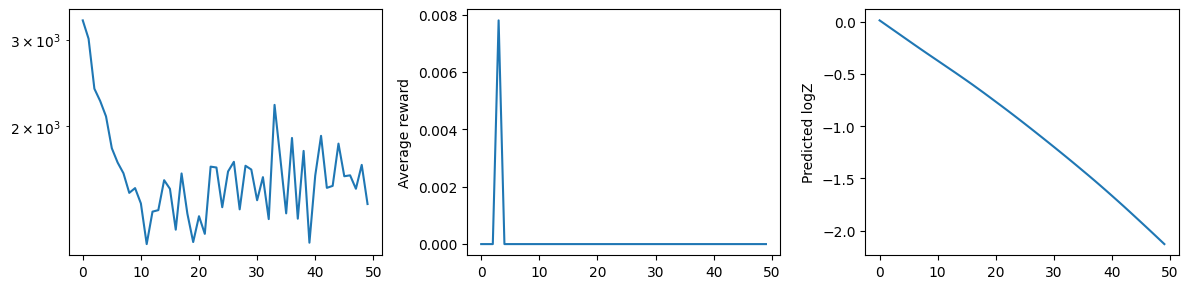

In [6]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator

cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[1].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()